# IMEC2001 Herramientas Computacionales 
## Clase 9 - ODE e integración


---
En la clase anterior exploramos la descripición de sistemas físicos a través de expresiones con variables dinámicas (dependientes del tiempo) en sympy. Ahora se observará cómo se pueden solucionar, encontrando valores de los estados en el tiempo partir de la integración de la ecuación diferencial. Esta integración se realizará con la función odeint de la librería scipy.

## TABLA DE CONTENIDO

- 1.1. Cargar Librerías
- 1.2. Definir ecuaciones de un sistemas dinámico
- 1.3  Expresar en espacio de estados
- 1.4. Expresiones numéricas
- 1.5. odeint

In [1]:
!pip install sympy


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1.1. Cargar Librerías

In [1]:
import sympy
from sympy import symbols
import scipy
import numpy as np
import matplotlib.pyplot as plt

def formato_grafica(titulo, ejex, ejey, leyenda=False, xlim=[None, None], ylim=[None, None]):
    plt.rcParams['axes.axisbelow'] = True

    plt.title(titulo, fontsize=15)
    plt.ylabel(ejey, fontsize=13)
    plt.xlabel(ejex, fontsize=13)

    plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
    plt.xticks(rotation=0)
    plt.minorticks_on()
    plt.ylim(ylim[0], ylim[1])
    plt.xlim(xlim[0], xlim[1])
    plt.grid(True)
    plt.grid(visible=True, which='major', color='grey', linestyle='-')
    plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', alpha=0.2)
    
    if leyenda == True:
        plt.legend(loc='best')
    
    plt.tight_layout;

Retomamos el sistema masa, resorte-amortiguador como se ve en la figura:
<div>
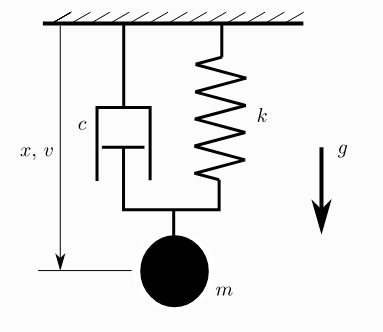
</div>
Este sistema se puede describir facilmente usando sympy así:

In [2]:

[k,m,c,t,g]=sympy.symbols('k,m,c,t,g')
x=sympy.Function('x')

F_resorte = -k * x(t)
F_amortiguador= -c * x(t).diff(t)
F_peso = m*g
sumFuerzas=F_resorte+F_amortiguador+F_peso
eom=sumFuerzas-m*x(t).diff(t,t)
eom

-c*Derivative(x(t), t) + g*m - k*x(t) - m*Derivative(x(t), (t, 2))

Eq(x(t), C1*exp(t*(-c + sqrt(c**2 - 4*k*m))/(2*m)) + C2*exp(-t*(c + sqrt(c**2 - 4*k*m))/(2*m)) + g*m/k)

## 1.4. Expresar ecuaciones en espacio de estados

In [56]:
#Definimos variables de estado x1 y x2, que conforman el vector de estados x=[x1,x2]
x1=sympy.Function('x1')
x2=sympy.Function('x2')

#Reemplazamos derivadas por variables de estado
dots={x(t).diff(t):x2(t),x(t):x1(t)}
eqs=[eom.subs(dots),x1(t).diff(t)-x2(t)]

eqs

[-c*x2(t) + g*m - k*x1(t) - m*Derivative(x2(t), t),
 -x2(t) + Derivative(x1(t), t)]

In [57]:
#Despejamos las derivadas de las variables de estado
sln=sympy.solve(eqs,[x1(t).diff(t),x2(t).diff(t)])
sln

{Derivative(x1(t), t): x2(t), Derivative(x2(t), t): -c*x2(t)/m + g - k*x1(t)/m}

In [62]:
# Podemos sacar el lado derecho de las ecuaciones diferenciales
# y agrupar en forma matricial.
rhs=[item[1] for item in sln.items()]
linear_eom=sympy.linear_eq_to_matrix(rhs,[x1(t),x2(t)])
A=linear_eom[0]
b=-linear_eom[1]
# En este caso tenemos que el sistema se puede describir como xdot=Ax+b
b

Matrix([
[0],
[g]])

## 1.4. Expresiones numericas
El sistema $\dot{x}=Ax+b$ relaciona el estado actual del sistema con el cambio en el estado del sistema. Entonces si conocemos un $x$ actual podemos saber cómo este $x$ va cambiar ya que podemos calcular su derivada en el tiempo ($\dot{x}$).

Para resolver numericamente tenemos que introducir valores numéricos en los parámetros del sistema.

In [63]:
params={g:9.81,m:1,c:0.25,k:1}

#Escribimos las ecuaciones de xdot con los parámetros numéricos:
eqs=A.subs(params)*sympy.Matrix([[x1(t)],[x2(t)]])+b.subs(params)

#Utilizamos lambdify para una evaluación eficiente de las ecuaciones
eqs_fun=[sympy.lambdify([x1(t),x2(t)],eq) for eq in eqs]

# Podemos evaluar x1_dot para x1=0, x2=1 así:
# eqs_fun[0](0,1)

# Ahora generamos una función que retorna xdot evaluado en un x1,x2 conocidos.
# Observe que en la función pasamos un argumento adicional para el tiempo. Este no se utiliza pero 
# es requerido para cumplir la estructura de la función odeint.

def ode_fun(x,t=None):
    x1dot=eqs_fun[0](x[0],x[1])
    x2dot=eqs_fun[1](x[0],x[1])
    return [x1dot,x2dot]

#Probemos evaluar en una valor arbitrario de x1,x2
ode_fun([0.1,0.2])

[0.2, 9.66]

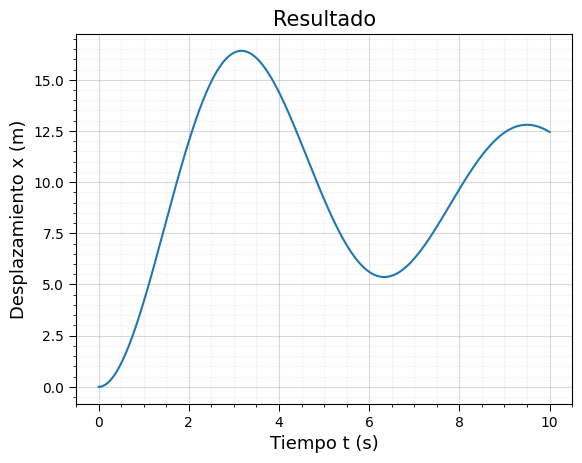

In [64]:
# Definimos un x0 correspondiente a condiciones iniciales conocidas
x0=[0,0]
# Definimos una lista de tiempos en los que vamos a guardar el resultado de la integración
tt=np.linspace(0,10,1000)
xx=scipy.integrate.odeint(ode_fun,x0,tt)

plt.plot(tt,xx[:,0])
formato_grafica('Resultado', 'Tiempo t (s)', 'Desplazamiento x (m)')